In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import csv
import unidecode
import geopandas as gpd
import math
import utm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import geopy.distance

In [2]:
# define algumas funções importantes

# utilizada para calcular a media ponderada usando o FE_VIA
def calculate_weighted_mean(data):
    data['FE_VIA'] = data['FE_VIA'].apply(lambda x: 1 if math.isnan(x) else x)
    data['FE_VIA'] = data['FE_VIA'].apply(lambda x: 1 if int(x) == 0 else x)
    data['MP'] = data['FE_VIA'] * data['DURACAO']
    return data

# calcula a distancia entre os pontos
def calculate_distance(row):  
    origin = utm.to_latlon(row['CO_O_X'],row['CO_O_Y'], 23, 'K')
    dest = utm.to_latlon(row['CO_D_X'],row['CO_D_Y'], 23, 'K')
    return geopy.distance.geodesic(origin, dest).meters


In [3]:
file = "../data/dados17.csv"

# carrega os dados de 2017
data17 = pd.read_csv(file, dtype={'ZONA_O': str, 'ZONA_D': str}, header=0,delimiter=";", low_memory=False) 
data17 = data17.dropna(subset=['CO_O_X'])

data17 = data17.drop(['ID_DOM', 'FE_DOM', 'VIA_BICI','TP_ESTBICI','F_FAM','FE_FAM','FAMILIA','NO_MORAF',
                      'CONDMORA','QT_BANHO','QT_EMPRE','QT_AUTO','QT_MICRO','QT_LAVALOU','QT_GEL1'], axis=1)

# calcula a distancia entre os pontos
data17['DISTANCE'] = data17.apply(lambda x: calculate_distance(x), axis=1)

# carrega os distritos
csv_file = "../data/regioes17.csv"
mydict = []
with open(csv_file, mode='r') as infile:
    reader = csv.reader(infile, delimiter=";")
    mydict = {rows[0]:rows[1] for rows in reader}

# carrega as zonas
csv_file = "../data/zonas17.csv"
zonas_nomes = []
with open(csv_file, mode='r') as infile:
    reader = csv.reader(infile, delimiter=";")
    zonas_nomes = {rows[0]:rows[1] for rows in reader}
    
# viagens so dentro do municipio de sao paulo
data17 = data17[data17['MUNI_O'] == 36]
data17 = data17[data17['MUNI_D'] == 36]


# troca os codigos pelo nome dos distritos e zonas
data17['NOME_O'] = data17['ZONA_O'].apply(lambda x: '' if pd.isnull(x) else mydict[x])
data17['NOME_D'] = data17['ZONA_D'].apply(lambda x: '' if pd.isnull(x) else mydict[x])

data17['ZONA_O'] = data17['ZONA_O'].apply(lambda x: '' if pd.isnull(x) else zonas_nomes[x])
data17['ZONA_D'] = data17['ZONA_D'].apply(lambda x: '' if pd.isnull(x) else zonas_nomes[x])

data17 = calculate_weighted_mean(data17)

In [4]:
# coloca o nome dos modos de viagens

modos17 = {0:'Outros',1:'Metrô',2:'Trem',3:'Metrô',4:'Ônibus',5:'Ônibus',6:'Ônibus',7:'Fretado', 8:'Escolar',9:'Carro (Mot)', 10: 'Carro (Pass)', 11:'Taxi', 12:'Aplicativo', 13:'Moto (Mot)', 14:'Moto (Pass)', 15:'Bicicleta', 16:'Pedestre', 17: 'Outros'}
data17['MODOPRIN'] = data17['MODOPRIN'].replace(modos17)

data17['MODOPRIN'].head()

0      Pedestre
1      Pedestre
2         Metrô
3         Metrô
4    Aplicativo
Name: MODOPRIN, dtype: object

In [5]:
# agrupa pelo modo da viagem e soma tudo
conj17 = data17[['MODOPRIN', 'FE_VIA']].groupby(['MODOPRIN']).sum().sort_values(by=['FE_VIA']).reset_index()
conj17.columns = ['MODOPRIN', 'FE_VIA']
conj17 = conj17.set_index('MODOPRIN')
conj17

,FE_VIA
MODOPRIN,
Fretado,3.337329e+04
Moto (Pass),3.875655e+04
Outros,5.402288e+04
Taxi,8.274082e+04
Bicicleta,2.045023e+05
Aplicativo,2.485057e+05
Moto (Mot),4.288413e+05
Trem,4.612448e+05
Escolar,1.109075e+06


<Figure size 2160x1440 with 0 Axes>

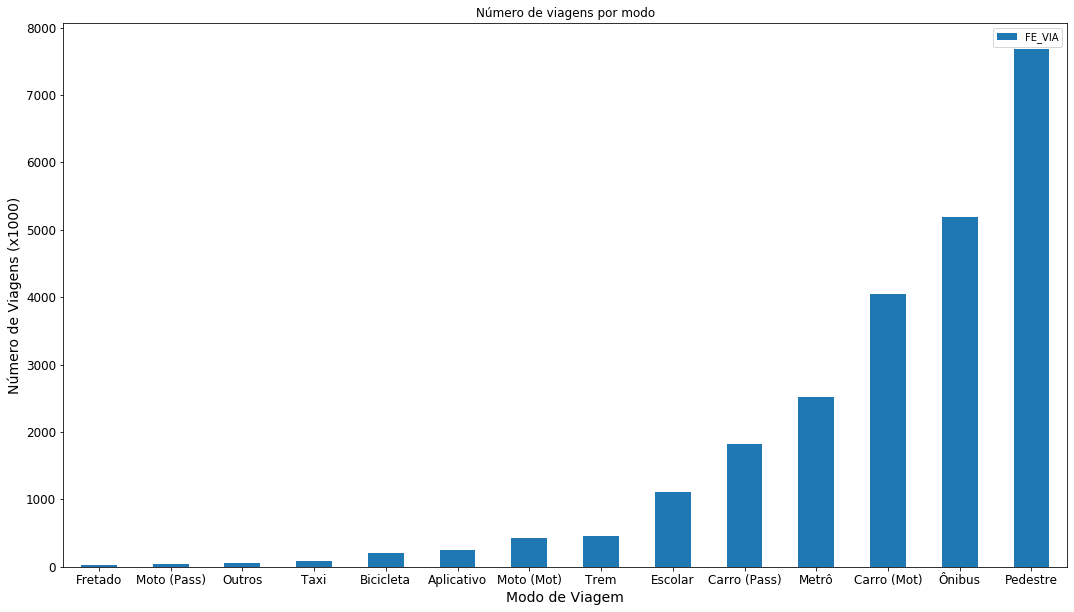

In [6]:
plt.figure(figsize=(30,20))

conj17['FE_VIA'] = conj17['FE_VIA'] / 1000
ax = conj17.plot.bar(y='FE_VIA', rot=0, title ="Número de viagens por modo", fontsize = 12)
ax.figure.set_size_inches(18,10)

plt.xlabel('Modo de Viagem', fontsize=14)
plt.ylabel('Número de Viagens (x1000)', fontsize=14)

# plot table
plt.show()

In [7]:
conj17

,FE_VIA
MODOPRIN,
Fretado,33.373288
Moto (Pass),38.756545
Outros,54.022884
Taxi,82.740818
Bicicleta,204.502333
Aplicativo,248.505666
Moto (Mot),428.841262
Trem,461.244814
Escolar,1109.074797


4 milhões de carro 200  mil de bicicleta

In [8]:
# numero total de viagens em SP

conj17['FE_VIA'].sum()

23934.151310251127

In [9]:
# agrupa o modo de viagem por distritos e filtro apenas para bicicletas

modo_distri = data17[['MODOPRIN', 'NOME_O', 'FE_VIA']].groupby(['MODOPRIN','NOME_O']).sum().sort_values(by=['FE_VIA']).reset_index()
modo_distri.columns = ['MODOPRIN', 'NOME_O', 'FE_VIA_BIKE']
modo_distri = modo_distri[modo_distri['MODOPRIN'] == 'Bicicleta']

modo_distri = modo_distri.set_index('NOME_O')

# agrupa o distrito e pega o total de viagens para cada
distrito = data17[['NOME_O', 'FE_VIA']].groupby(['NOME_O']).sum().sort_values(by=['FE_VIA']).reset_index()
distrito.columns = ['NOME_O', 'FE_VIA_TOTAL']
distrito = distrito.set_index('NOME_O')

# junta os dois dfs
modo_distri = modo_distri.join(distrito)

# calcula a % de viagens de bicicleta
modo_distri = modo_distri.drop(['MODOPRIN'], axis=1)
modo_distri['PORCETAGEM'] = modo_distri['FE_VIA_BIKE'] / modo_distri['FE_VIA_TOTAL'] * 100
modo_distri.columns = ['Bicicleta', 'Total', 'Bicicleta (%)']
modo_distri = modo_distri.round(2)
modo_distri['Bicicleta'] = modo_distri['Bicicleta'].round(0)
modo_distri['Total'] = modo_distri['Total'].round(0)
modo_distri.sort_values(by=['Bicicleta (%)'],ascending=False).head(10)


,Bicicleta,Total,Bicicleta (%)
NOME_O,,,
Vila Guilherme,7184.0,147084.0,4.88
Jardim Helena,8629.0,204378.0,4.22
Jaguare,3293.0,98784.0,3.33
Ipiranga,10386.0,318122.0,3.26
Vila Maria,7304.0,227562.0,3.21
Iguatemi,6567.0,211175.0,3.11
Socorro,3062.0,118084.0,2.59
Pari,1711.0,72105.0,2.37
Pinheiros,8215.0,366260.0,2.24


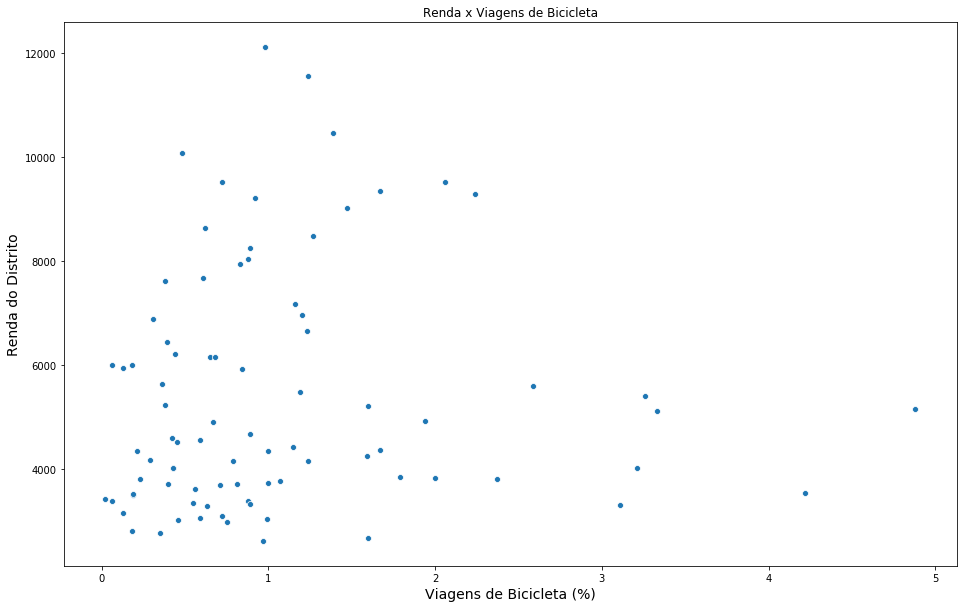

               Bicicleta     Total  Bicicleta (%)  RENDA_FA
Bicicleta       1.000000  0.190898       0.790813  0.190419
Total           0.190898  1.000000      -0.290611  0.069306
Bicicleta (%)   0.790813 -0.290611       1.000000  0.053798
RENDA_FA        0.190419  0.069306       0.053798  1.000000


In [10]:
# verifica a relação entre RENDA e viagens de bicicleta

distri_renda = data17[['NOME_O', 'RENDA_FA']].groupby(['NOME_O']).mean().sort_values(by=['RENDA_FA']).reset_index()
distri_renda.columns = ['NOME_O', 'RENDA_FA']

distri_renda = distri_renda.set_index('NOME_O')
distri_renda.tail()


distri_renda = modo_distri.join(distri_renda)
distri_renda

plt.figure(figsize=(16,10))

sns.scatterplot(x="Bicicleta (%)", y="RENDA_FA", data=distri_renda).set_title('Renda x Viagens de Bicicleta')
plt.xlabel('Viagens de Bicicleta (%)', fontsize=14)
plt.ylabel('Renda do Distrito', fontsize=14)
plt.show()

print(distri_renda.corr())

                 Bicicleta     Total  Bicicleta (%)      media
NOME_O                                                        
Brasilandia          485.0  376310.0           0.13  34.097368
Jardim Paulista     3677.0  397583.0           0.92  30.651802
Iguatemi            6567.0  211175.0           3.11  30.454538
Mandaqui            1513.0  181201.0           0.84  30.321233
Tremembe            3769.0  353133.0           1.07  28.252254
...                    ...       ...            ...        ...
Itaim Bibi         11245.0  547034.0           2.06   7.447969
Bom Retiro          2785.0  143674.0           1.94   7.111569
Bras                1715.0  171126.0           1.00   3.591560
Jardim Helena       8629.0  204378.0           4.22   3.415375
Pari                1711.0   72105.0           2.37   3.223350

[84 rows x 4 columns]


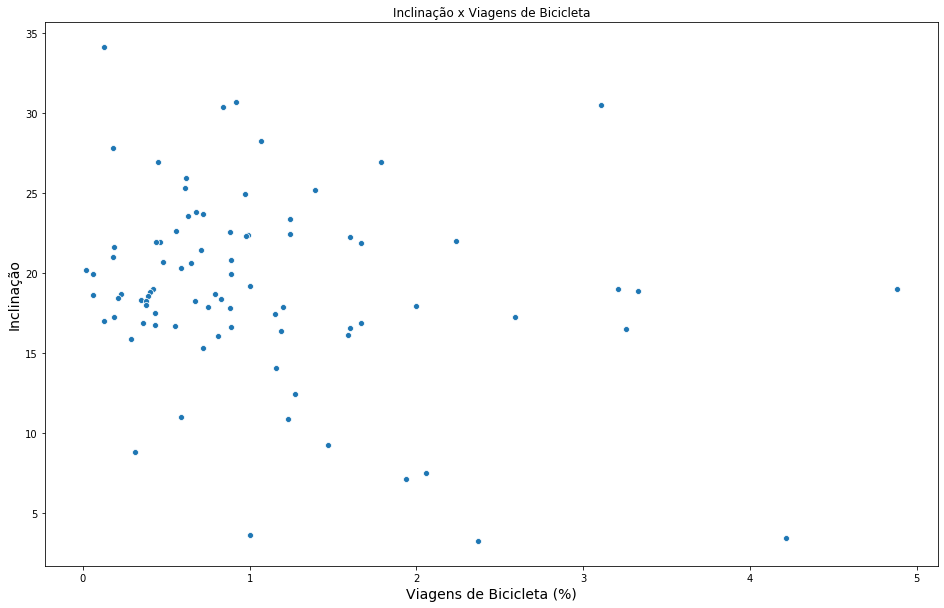

               Bicicleta     Total  Bicicleta (%)     media
Bicicleta       1.000000  0.190898       0.790813 -0.182034
Total           0.190898  1.000000      -0.290611  0.177365
Bicicleta (%)   0.790813 -0.290611       1.000000 -0.283646
media          -0.182034  0.177365      -0.283646  1.000000


In [42]:
inclinacao = pd.read_csv("../data/distrito_inclinacao.csv", encoding='latin-1')
inclinacao = inclinacao.set_index('NomeDistri')


zona_inclinacao = modo_distri.join(inclinacao)

zona_inclinacao = zona_inclinacao.sort_values(by=['media'], ascending=False)

print(zona_inclinacao)

plt.figure(figsize=(16,10))

sns.scatterplot(x="Bicicleta (%)", y="media", data=zona_inclinacao).set_title('Inclinação x Viagens de Bicicleta')
plt.xlabel('Viagens de Bicicleta (%)', fontsize=14)
plt.ylabel('Inclinação', fontsize=14)
plt.show()
print(distri_inclinacao.corr())


In [12]:
conj17['POR'] = conj17['FE_VIA'] / conj17['FE_VIA'].sum() * 100
conj17

,FE_VIA,POR
MODOPRIN,,
Fretado,33.373288,0.139438
Moto (Pass),38.756545,0.161930
Outros,54.022884,0.225715
Taxi,82.740818,0.345702
Bicicleta,204.502333,0.854437
Aplicativo,248.505666,1.038289
Moto (Mot),428.841262,1.791755
Trem,461.244814,1.927141
Escolar,1109.074797,4.633859


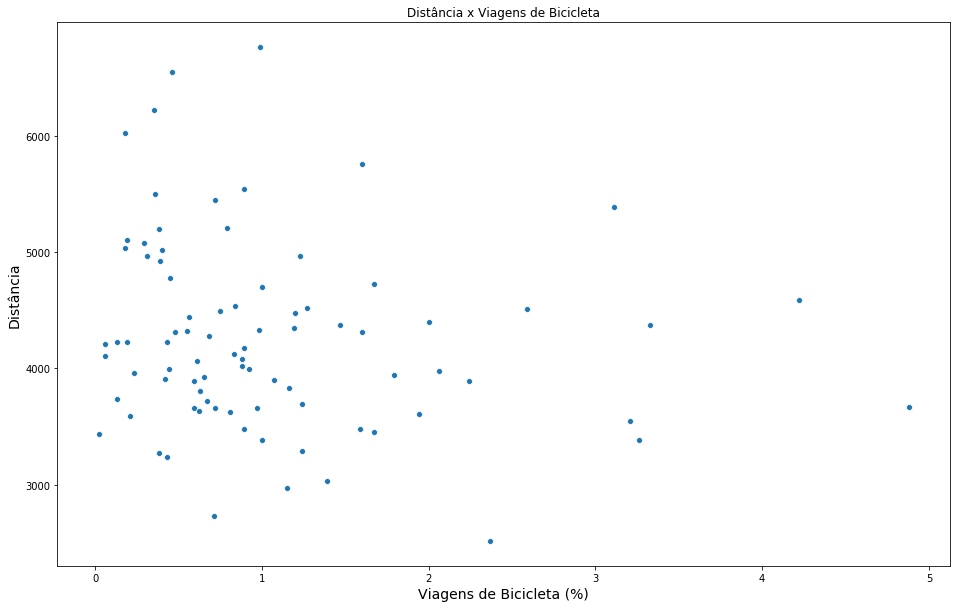

               Bicicleta     Total  Bicicleta (%)  DISTANCE
Bicicleta       1.000000  0.190898       0.790813 -0.101630
Total           0.190898  1.000000      -0.290611  0.142585
Bicicleta (%)   0.790813 -0.290611       1.000000 -0.157357
DISTANCE       -0.101630  0.142585      -0.157357  1.000000


In [44]:
distri_renda = data17[['NOME_O', 'DISTANCE']].groupby(['NOME_O']).mean().sort_values(by=['DISTANCE']).reset_index()
distri_renda.columns = ['NOME_O', 'DISTANCE']

distri_renda = distri_renda.set_index('NOME_O')
distri_renda.tail()


distri_renda = modo_distri.join(distri_renda)
distri_renda

plt.figure(figsize=(16,10))

sns.scatterplot(x="Bicicleta (%)", y="DISTANCE", data=distri_renda).set_title('Distância x Viagens de Bicicleta')
plt.xlabel('Viagens de Bicicleta (%)', fontsize=14)
plt.ylabel('Distância', fontsize=14)
plt.show()

print(distri_renda.corr())

20 vezes mais ciagens de carro

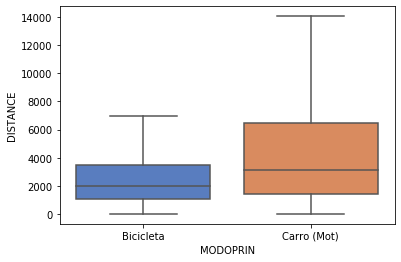

In [13]:
bicicleta = data17[data17['MODOPRIN'] == 'Bicicleta']

carro = data17[data17['MODOPRIN'] == 'Carro (Mot)']


total = bicicleta.append(carro)
total.head()

sns.boxplot(x="MODOPRIN", y="DISTANCE", data=total, palette="muted", showfliers = False)



Apesar das viagens de bicicletas serem menores que as de carro, metade das viagens de carro tem distâncias iguais ou menores que 75% viagens de bicicletas

In [14]:
flows = pd.read_csv("../data/flows.csv", encoding='latin-1')
lines = []
viagens = []

flows = flows.set_index('index')

flows = flows.join(data17, lsuffix='_left', rsuffix='_right')

In [15]:
flows_dist = flows[flows['MODOPRIN'] == 'Carro (Mot)']
flows_dist['FE_VIA'].sum()

375844.514095

375 mil viagens feitas de carro tem menos de 6km e inclinição máxima de 4%

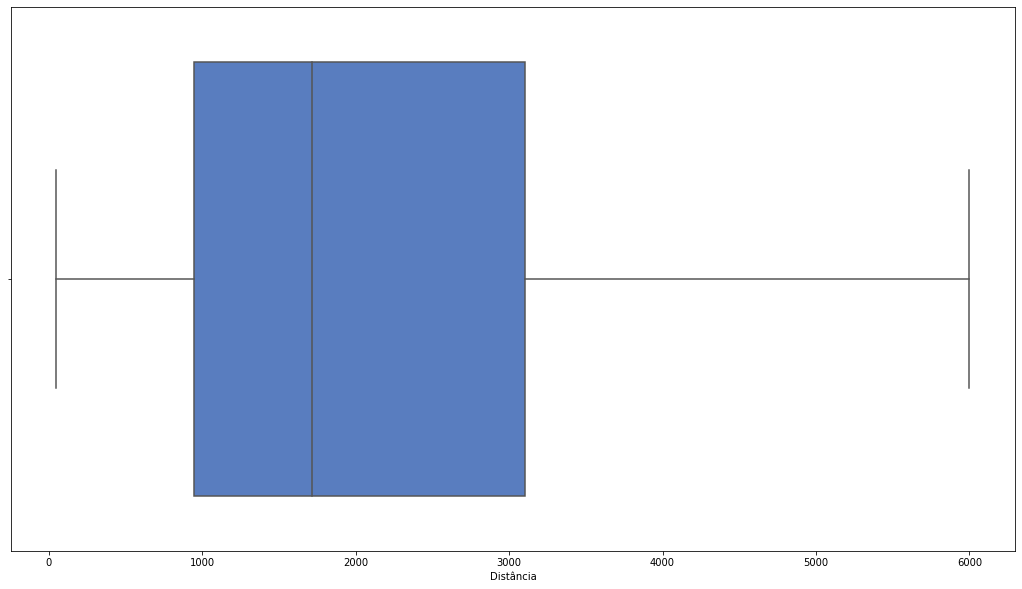

In [16]:
ax = sns.boxplot(x="DISTANCE", data=flows_dist, palette="muted", showfliers = False)
ax.set_xlabel("Distância")
ax.figure.set_size_inches(18,10)
plt.show()


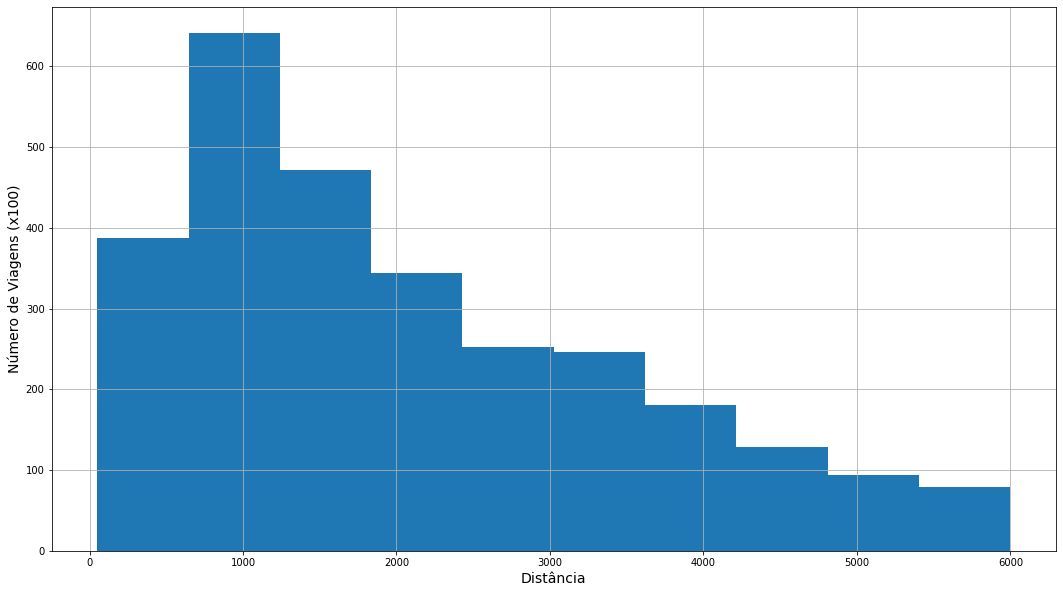

In [17]:
plt.figure(figsize=(30,20))
# plot chart

ax = flows_dist['DISTANCE'].hist()
ax.figure.set_size_inches(18,10)

plt.xlabel('Distância', fontsize=14)
plt.ylabel('Número de Viagens (x100)', fontsize=14)

# plot table
plt.show()


Apesar de termos considerado 6km, a maioria dessas viagens tem até 3km

In [18]:
flows = pd.read_csv("../data/flows.csv", encoding='latin-1')
lines = []
viagens = []

flows = flows.set_index('index')

flows = flows.join(data17, lsuffix='_left', rsuffix='_right')

distri = flows[['NOME_O', 'FE_VIA']].groupby(['NOME_O']).sum().sort_values(by=['FE_VIA'],ascending=False).reset_index()
distri.columns = ['NOME_O', 'FE_VIA_CARRO']
distri = distri.set_index('NOME_O')
distri['FE_VIA_CARRO'] = distri['FE_VIA_CARRO'].astype(int)
distri.columns = ['Viagens']
distri.head(10)

,Viagens
NOME_O,
Santo Amaro,41907
Jardim Helena,28150
Itaim Bibi,25185
Mooca,16908
Moema,16351
Jabaquara,14105
Ipiranga,14035
Tatuape,13964
Saude,13940


In [19]:
bicicleta = data17[data17['MODOPRIN'] == 'Bicicleta']
distri_atual = bicicleta[['NOME_O', 'FE_VIA']].groupby(['NOME_O']).sum().sort_values(by=['FE_VIA']).reset_index()
distri_atual.columns = ['NOME_O', 'FE_VIA_BICI']
distri_atual = distri_atual.set_index('NOME_O')
distri_atual.head(10)

,FE_VIA_BICI
NOME_O,
Cidade Ademar,66.958224
Capao Redondo,268.767697
Tucuruvi,271.691487
Jabaquara,283.990582
Vila Medeiros,355.589808
Vila Matilde,434.112580
Campo Grande,471.568874
Brasilandia,485.014355
Guaianases,659.915535


In [20]:
total = distri.join(distri_atual)
total.head(10)

,Viagens,FE_VIA_BICI
NOME_O,,
Santo Amaro,41907,1996.199482
Jardim Helena,28150,8628.820164
Itaim Bibi,25185,11245.446740
Mooca,16908,2913.315667
Moema,16351,4765.634372
Jabaquara,14105,283.990582
Ipiranga,14035,10385.901690
Tatuape,13964,1312.786980
Saude,13940,4052.589286


In [21]:
total['POR'] = total['FE_VIA_BICI'] / (total['Viagens'] + total['FE_VIA_BICI']) * 100
total.head(10)

,Viagens,FE_VIA_BICI,POR
NOME_O,,,
Santo Amaro,41907,1996.199482,4.546820
Jardim Helena,28150,8628.820164,23.461384
Itaim Bibi,25185,11245.446740,30.868265
Mooca,16908,2913.315667,14.697892
Moema,16351,4765.634372,22.568153
Jabaquara,14105,283.990582,1.973666
Ipiranga,14035,10385.901690,42.528740
Tatuape,13964,1312.786980,8.593345
Saude,13940,4052.589286,22.523658


In [22]:
flows['H_SAIDA'].head()

index
826     23.0
1181    22.0
1444     2.0
1676    16.0
1720    16.0
Name: H_SAIDA, dtype: float64

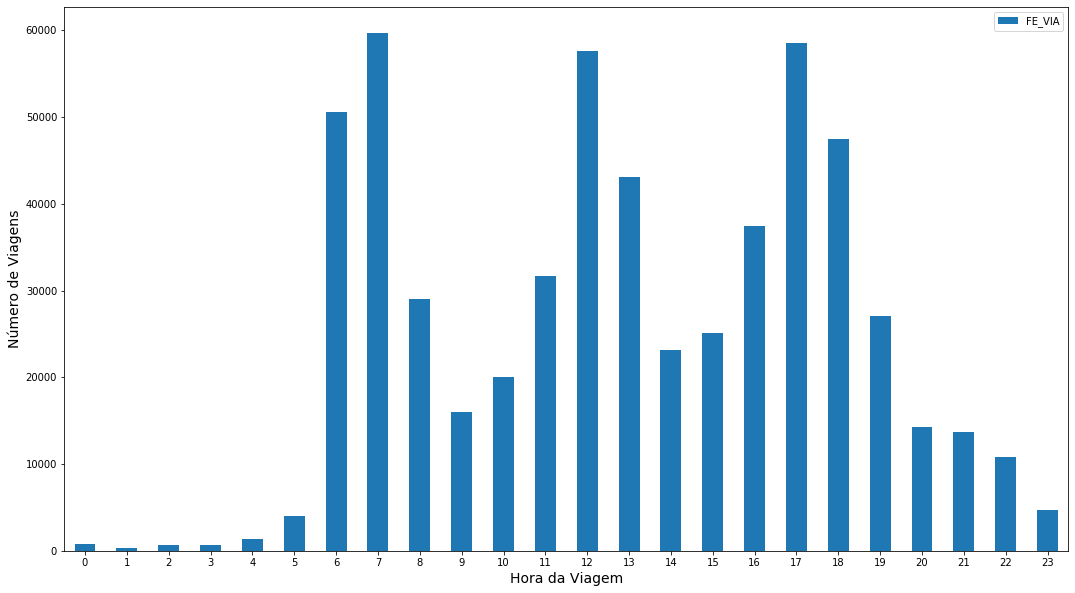

In [23]:
hsaida = flows[['H_SAIDA', 'FE_VIA']].groupby(['H_SAIDA']).sum().sort_values(by=['H_SAIDA']).reset_index()
hsaida.columns = ['H_SAIDA', 'FE_VIA']

hsaida['H_SAIDA'] = hsaida['H_SAIDA'].astype(int)

ax = hsaida.plot.bar(x='H_SAIDA', y='FE_VIA', rot=0)
ax.figure.set_size_inches(18,10)

plt.xlabel('Hora da Viagem', fontsize=14)
plt.ylabel('Número de Viagens', fontsize=14)

plt.show()

In [24]:
flows = pd.read_csv("../data/flows_public.csv", encoding='latin-1')
lines = []
viagens = []

flows = flows.set_index('index')

flows = flows.join(data17, lsuffix='_left', rsuffix='_right')

distri = flows[['NOME_O', 'FE_VIA']].groupby(['NOME_O']).sum().sort_values(by=['FE_VIA'],ascending=False).reset_index()
distri.columns = ['NOME_O', 'FE_VIA_CARRO']
distri = distri.set_index('NOME_O')
distri['FE_VIA_CARRO'] = distri['FE_VIA_CARRO'].astype(int)
distri.columns = ['Viagens']
distri.head(10)

,Viagens
NOME_O,
Santo Amaro,17940
Mooca,17168
Sao Miguel,13407
Itaquera,12298
Itaim Paulista,12190
Jardim Helena,9976
Belem,8980
Bras,8740
Sapopemba,7926


In [25]:
distri['Viagens'].sum()

336474

In [26]:
modo = flows[['MODOPRIN', 'FE_VIA']].groupby(['MODOPRIN']).sum().sort_values(by=['FE_VIA'],ascending=False).reset_index()
modo.columns = ['MODOPRIN', 'FE_VIA_TRANS']
modo = modo.set_index('MODOPRIN')
modo['FE_VIA_TRANS'] = modo['FE_VIA_TRANS'].astype(int)
modo.columns = ['Viagens']
modo.head(10)

,Viagens
MODOPRIN,
Ônibus,281900
Metrô,48800
Trem,5814


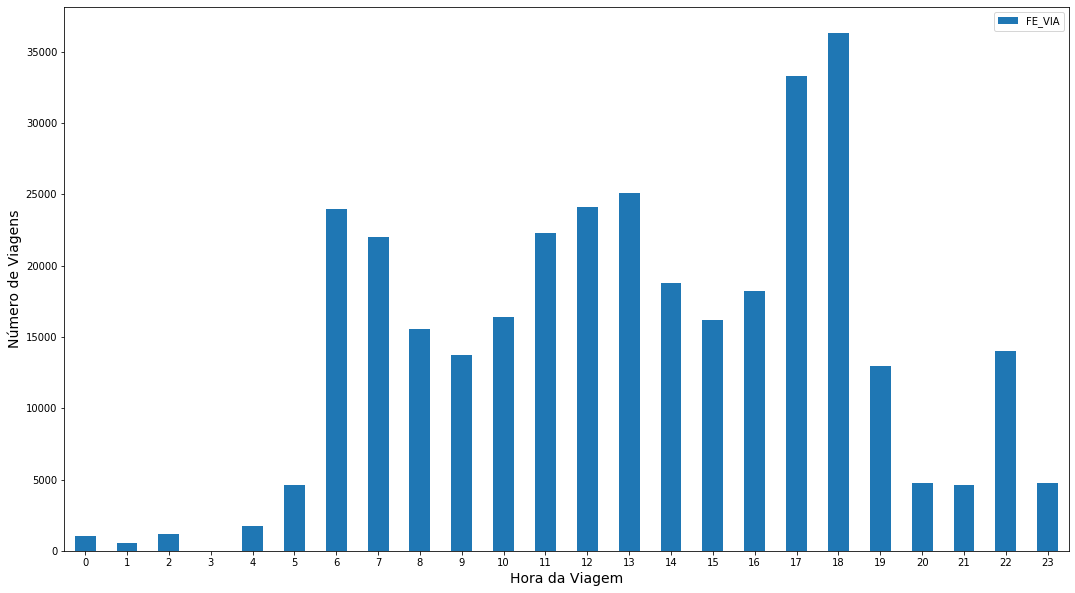

In [27]:
hsaida = flows[['H_SAIDA', 'FE_VIA']].groupby(['H_SAIDA']).sum().sort_values(by=['H_SAIDA']).reset_index()
hsaida.columns = ['H_SAIDA', 'FE_VIA']

hsaida['H_SAIDA'] = hsaida['H_SAIDA'].astype(int)

ax = hsaida.plot.bar(x='H_SAIDA', y='FE_VIA', rot=0)
ax.figure.set_size_inches(18,10)

plt.xlabel('Hora da Viagem', fontsize=14)
plt.ylabel('Número de Viagens', fontsize=14)

plt.show()

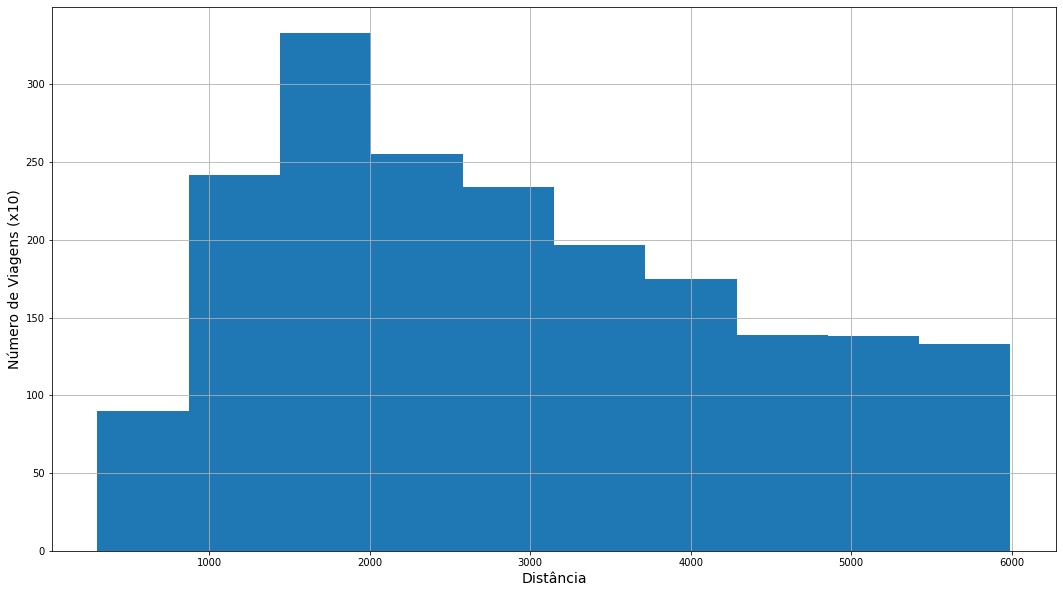

In [28]:
flows = pd.read_csv("../data/flows_public.csv", encoding='latin-1')
lines = []
viagens = []

flows = flows.set_index('index')
flows = flows.join(data17, lsuffix='_left', rsuffix='_right')

flows['FE_VIA'].sum()

plt.figure(figsize=(30,20))
# plot chart

ax = flows['DISTANCE'].hist()
ax.figure.set_size_inches(18,10)

plt.xlabel('Distância', fontsize=14)
plt.ylabel('Número de Viagens (x10)', fontsize=14)

# plot table
plt.show()